In [116]:
import os
!nvidia-smi -L

GPU 0: NVIDIA RTX 6000 Ada Generation (UUID: GPU-74e2b222-7a24-27b5-7b17-e0afbc96e2f6)
GPU 1: NVIDIA RTX 6000 Ada Generation (UUID: GPU-d42f3d8b-4a1f-cb4a-1212-fd20aa7b0c68)


In [117]:
import numpy as np
import typing
import pandas as pd
import matplotlib.pyplot as plt

In [118]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [119]:
import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = ''    

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


I0000 00:00:1747330969.961979 3486962 gpu_device.cc:2019] Created device /device:GPU:0 with 297 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1747330969.962323 3486962 gpu_device.cc:2019] Created device /device:GPU:1 with 45009 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:41:00.0, compute capability: 8.9


In [120]:
#!git clone "https://github.com/VeritasYin/STGCN_IJCAI-18"
#!unzip STGCN_IJCAI-18/dataset/PeMSD7_Full.zip

In [121]:
route_distances = pd.read_csv(("PeMSD7_W_1026.csv"), header=None).to_numpy()


In [122]:
print(f"route_distances shape={route_distances.shape}")


route_distances shape=(1026, 1026)


In [123]:
speeds_array = pd.read_csv(("PeMSD7_V_1026.csv"), header=None).to_numpy()


In [124]:
print(f"speeds_array shape={speeds_array.shape}")


speeds_array shape=(12672, 1026)


In [125]:
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]

In [126]:
route_distances = route_distances[np.ix_(sample_routes, sample_routes)]
speeds_array = speeds_array[:, sample_routes]

In [127]:
print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


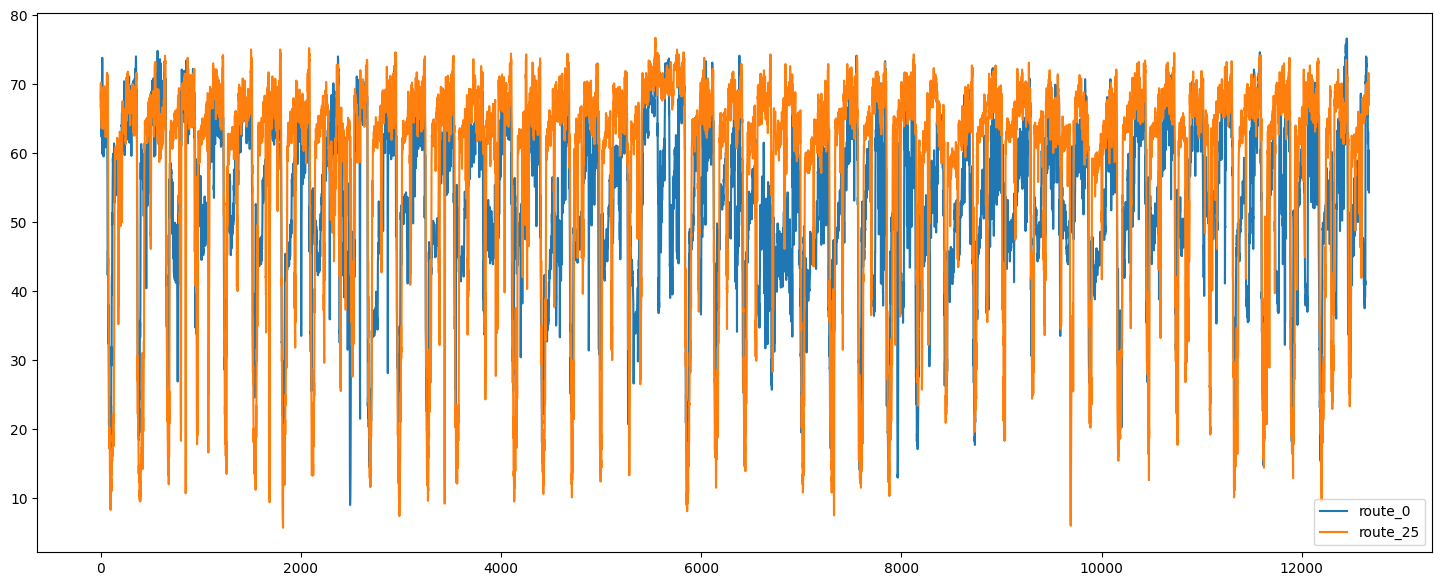

In [128]:
plt.figure(figsize=(18, 7))
plt.plot(speeds_array[:, [0, -1]])
plt.legend(["route_0", "route_25"])

Text(0, 0.5, 'road number')

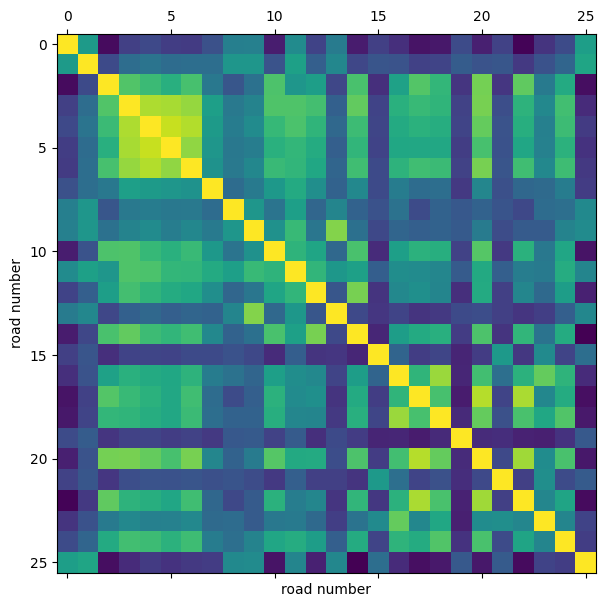

In [129]:
plt.figure(figsize=(9, 7))
plt.matshow(np.corrcoef(speeds_array.T), 0)
plt.xlabel("road number")
plt.ylabel("road number")

In [130]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array

In [131]:
train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)


In [132]:
print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)


In [133]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False

In [134]:
def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()

In [135]:
train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

In [136]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

In [137]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 26, number of edges: 52


In [138]:
# class GraphConv(layers.Layer):
#     def __init__(
#         self,
#         in_feat,
#         out_feat,
#         graph_info: GraphInfo,
#         aggregation_type="mean",
#         combination_type="concat",
#         activation: typing.Optional[str] = None,
#         **kwargs,
#     ):
#         super().__init__(**kwargs)
#         self.in_feat = in_feat
#         self.out_feat = out_feat
#         self.graph_info = graph_info
#         self.aggregation_type = aggregation_type
#         self.combination_type = combination_type
#         self.weight = tf.Variable(
#             initial_value=keras.initializers.glorot_uniform()(
#                 shape=(in_feat, out_feat), dtype="float32"
#             ),
#             trainable=True,
#         )
#         self.activation = layers.Activation(activation)

#     def aggregate(self, neighbour_representations: tf.Tensor):
#         aggregation_func = {
#             "sum": tf.math.unsorted_segment_sum,
#             "mean": tf.math.unsorted_segment_mean,
#             "max": tf.math.unsorted_segment_max,
#         }.get(self.aggregation_type)

#         if aggregation_func:
#             return aggregation_func(
#                 neighbour_representations,
#                 self.graph_info.edges[0],
#                 num_segments=self.graph_info.num_nodes,
#             )

#         raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

#         def compute_nodes_representation(self, features: tf.Tensor):
#             """Computes each node's representation.
    
#             The nodes' representations are obtained by multiplying the features tensor with
#             `self.weight`. Note that
#             `self.weight` has shape `(in_feat, out_feat)`.
    
#             Args:
#                 features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`
    
#             Returns:
#                 A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
#             """
#             return tf.matmul(features, self.weight)

#     def compute_aggregated_messages(self, features: tf.Tensor):
#         neighbour_representations = tf.gather(features, self.graph_info.edges[1])
#         aggregated_messages = self.aggregate(neighbour_representations)
#         return tf.matmul(aggregated_messages, self.weight)

#     def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
#         if self.combination_type == "concat":
#             h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
#         elif self.combination_type == "add":
#             h = nodes_representation + aggregated_messages
#         else:
#             raise ValueError(f"Invalid combination type: {self.combination_type}.")

#         return self.activation(h)

#     def call(self, features: tf.Tensor):
#         """Forward pass.

#         Args:
#             features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

#         Returns:
#             A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
#         """
#         nodes_representation = self.compute_nodes_representation(features)
#         aggregated_messages = self.compute_aggregated_messages(features)
#         return self.update(nodes_representation, aggregated_messages)

In [139]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import typing

# Define GraphInfo class (as provided previously)
class GraphInfo:
    def __init__(self, edges, num_nodes):
        self.edges = edges  # Tuple of (source, target) node indices
        self.num_nodes = num_nodes

# Define GraphConv layer
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.activation = layers.Activation(activation)

    def build(self, input_shape):
        # Initialize weight matrix
        self.weight = self.add_weight(
            name='weight',
            shape=(self.in_feat, self.out_feat),
            initializer='glorot_uniform',
            trainable=True
        )
        # Initialize bias
        self.bias = self.add_weight(
            name='bias',
            shape=(self.out_feat,),
            initializer='zeros',
            trainable=True
        )
        self.built = True

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation."""
        return tf.matmul(features, self.weight) + self.bias

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight) + self.bias

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass."""
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], self.out_feat)

# Define LSTMGC layer
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""
    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.lstm_units = lstm_units
        self.input_seq_len = input_seq_len
        self.output_seq_len = output_seq_len
        self.graph_info = graph_info

        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)
        self.lstm = layers.LSTM(lstm_units, activation="relu", return_sequences=False)
        self.dense = layers.Dense(output_seq_len * graph_info.num_nodes)

    def build(self, input_shape):
        graph_conv_input_shape = (input_shape[2], input_shape[0], input_shape[1], input_shape[3])
        self.graph_conv.build(graph_conv_input_shape)
        lstm_input_shape = (input_shape[0] * input_shape[2], input_shape[1], self.out_feat)
        self.lstm.build(lstm_input_shape)
        dense_input_shape = (input_shape[0] * input_shape[2], self.lstm_units)
        self.dense.build(dense_input_shape)
        self.built = True

    def call(self, inputs):
        inputs = tf.transpose(inputs, [2, 0, 1, 3])
        gcn_out = self.graph_conv(inputs)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = shape[0], shape[1], shape[2], shape[3]
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(gcn_out)
        dense_output = self.dense(lstm_out)
        output = tf.reshape(dense_output, (batch_size, num_nodes, self.output_seq_len))
        return tf.transpose(output, [0, 2, 1])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_seq_len, input_shape[2])

# Define graph (example)
num_nodes = 26
adj_matrix = np.random.randint(0, 2, size=(num_nodes, num_nodes))
adj_matrix = (adj_matrix + adj_matrix.T) / 2
adj_matrix = np.where(np.eye(num_nodes), 0, adj_matrix)
edges = np.where(adj_matrix)
edges = (edges[0], edges[1])
graph = GraphInfo(edges=edges, num_nodes=num_nodes)

# Model parameters
in_feat = 1
batch_size = 64
epochs = 50
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

# Initialize LSTMGC layer
st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)

# Define model
inputs = layers.Input((input_sequence_length, num_nodes, in_feat))
outputs = st_gcn(inputs)  # Corrected from st_gcn(input)
model = keras.models.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)

# Print model summary
model.summary()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [109]:
# class LSTMGC(layers.Layer):
#     """Layer comprising a convolution layer followed by LSTM and dense layers."""

#     def __init__(
#         self,
#         in_feat,
#         out_feat,
#         lstm_units: int,
#         input_seq_len: int,
#         output_seq_len: int,
#         graph_info: GraphInfo,
#         graph_conv_params: typing.Optional[dict] = None,
#         **kwargs,
#     ):
#         super().__init__(**kwargs)

#         # graph conv layer
#         if graph_conv_params is None:
#             graph_conv_params = {
#                 "aggregation_type": "mean",
#                 "combination_type": "concat",
#                 "activation": None,
#             }
#         self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

#         self.lstm = layers.LSTM(lstm_units, activation="relu")
#         self.dense = layers.Dense(output_seq_len)

#         self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

#     def call(self, inputs):
#         """Forward pass.

#         Args:
#             inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

#         Returns:
#             A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
#         """

#         # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
#         inputs = tf.transpose(inputs, [2, 0, 1, 3])

#         gcn_out = self.graph_conv(
#             inputs
#         )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
#         shape = tf.shape(gcn_out)
#         num_nodes, batch_size, input_seq_len, out_feat = (
#             shape[0],
#             shape[1],
#             shape[2],
#             shape[3],
#         )

#         # LSTM takes only 3D tensors as input
#         gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
#         lstm_out = self.lstm(
#             gcn_out
#         )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

#         dense_output = self.dense(
#             lstm_out
#         )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
#         output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
#         return tf.transpose(
#             output, [1, 2, 0]
#         )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

In [110]:
# class LSTMGC(layers.Layer):
#     """Layer comprising a convolution layer followed by LSTM and dense layers."""

#     def __init__(
#         self,
#         in_feat,
#         out_feat,
#         lstm_units: int,
#         input_seq_len: int,
#         output_seq_len: int,
#         graph_info: GraphInfo,
#         graph_conv_params: typing.Optional[dict] = None,
#         **kwargs,
#     ):
#         super().__init__(**kwargs)
#         self.in_feat = in_feat
#         self.out_feat = out_feat
#         self.lstm_units = lstm_units
#         self.input_seq_len = input_seq_len
#         self.output_seq_len = output_seq_len
#         self.graph_info = graph_info

#         # Graph convolution layer
#         if graph_conv_params is None:
#             graph_conv_params = {
#                 "aggregation_type": "mean",
#                 "combination_type": "concat",
#                 "activation": None,
#             }
#         self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

#         # LSTM layer
#         self.lstm = layers.LSTM(lstm_units, activation="relu", return_sequences=False)

#         # Dense layer
#         self.dense = layers.Dense(output_seq_len * graph_info.num_nodes)

#     def build(self, input_shape):
#         # Input shape: (batch_size, input_seq_len, num_nodes, in_feat)
#         graph_conv_input_shape = (input_shape[2], input_shape[0], input_shape[1], input_shape[3])
#         self.graph_conv.build(graph_conv_input_shape)
#         # After graph conv: (num_nodes, batch_size, input_seq_len, out_feat)
#         lstm_input_shape = (input_shape[0] * input_shape[2], input_shape[1], self.out_feat)
#         self.lstm.build(lstm_input_shape)
#         # After LSTM: (batch_size * num_nodes, lstm_units)
#         dense_input_shape = (input_shape[0] * input_shape[2], self.lstm_units)
#         self.dense.build(dense_input_shape)
#         self.built = True

#     def call(self, inputs):
#         """Forward pass.

#         Args:
#             inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

#         Returns:
#             A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
#         """
#         # Convert shape to (num_nodes, batch_size, input_seq_len, in_feat)
#         inputs = tf.transpose(inputs, [2, 0, 1, 3])

#         # Graph convolution
#         gcn_out = self.graph_conv(inputs)  # Shape: (num_nodes, batch_size, input_seq_len, out_feat)
#         shape = tf.shape(gcn_out)
#         num_nodes, batch_size, input_seq_len, out_feat = shape[0], shape[1], shape[2], shape[3]

#         # Reshape for LSTM
#         gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
#         lstm_out = self.lstm(gcn_out)  # Shape: (batch_size * num_nodes, lstm_units)

#         # Dense layer
#         dense_output = self.dense(lstm_out)  # Shape: (batch_size * num_nodes, output_seq_len * num_nodes)
#         output = tf.reshape(dense_output, (batch_size, num_nodes, self.output_seq_len))
#         return tf.transpose(output, [0, 2, 1])  # Shape: (batch_size, output_seq_len, num_nodes)

#     def compute_output_shape(self, input_shape):
#         return (input_shape[0], self.output_seq_len, input_shape[2])

In [111]:
# in_feat = 1
# batch_size = 64
# epochs = 50
# input_sequence_length = 12
# forecast_horizon = 3
# multi_horizon = False
# out_feat = 10
# lstm_units = 64
# graph_conv_params = {
#     "aggregation_type": "mean",
#     "combination_type": "concat",
#     "activation": None,
# }

# st_gcn = LSTMGC(
#     in_feat,
#     out_feat,
#     lstm_units,
#     input_sequence_length,
#     forecast_horizon,
#     graph,
#     graph_conv_params,
# )
# inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
# outputs = st_gcn(inputs)

# model = keras.models.Model(inputs, outputs)
# model.compile(
#     optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
#     loss=keras.losses.MeanSquaredError(),
# )

In [115]:
# in_feat = 1
# batch_size = 64
# epochs = 50
# input_sequence_length = 12
# forecast_horizon = 3
# multi_horizon = False
# out_feat = 10
# lstm_units = 64
# graph_conv_params = {
#     "aggregation_type": "mean",
#     "combination_type": "concat",
#     "activation": None,
# }

# # Initialize LSTMGC layer
# st_gcn = LSTMGC(
#     in_feat,
#     out_feat,
#     lstm_units,
#     input_sequence_length,
#     forecast_horizon,
#     graph,
#     graph_conv_params,
# )

# # Define model
# inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
# outputs = st_gcn(input)
# model = keras.models.Model(inputs, outputs)

# # Compile model
# model.compile(
#     optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
#     loss=keras.losses.MeanSquaredError(),
# )

# # Print model summary
# model.summary()

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x72f5b0ae59c0>> (of type <class 'method'>)